# Week 11 - Regression and Classification

In previous weeks we have looked at the steps needed in preparing different types of data for use by machine learning algorithms. 

In [8]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

(442, 10) (442,)


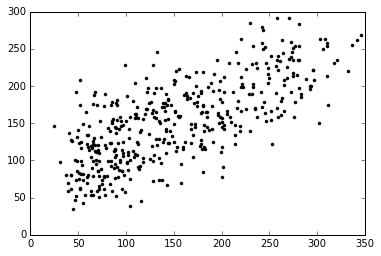

In [13]:
from sklearn import datasets

diabetes = datasets.load_diabetes()

# Description at http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

X = diabetes.data
y = diabetes.target

print(X.shape, y.shape)

from sklearn import linear_model

clf = linear_model.LinearRegression()
clf.fit(X, y)

plt.plot(y, clf.predict(X), 'k.')
plt.show()

All the different models in scikit-learn follow a consistent structure. 

* The class is passed any parameters needed at initialization. In this case none are needed.
* The fit method takes the features and the target as the parameters X and y.
* The predict method takes an array of features and returns the predicted values

These are the basic components with additional methods added when needed. For example, classifiers also have 

* A predict_proba method that gives the probability that a sample belongs to each of the classes.
* A predict_log_proba method that gives the log of the probability that a sample belongs to each of the classes.

## Evaluating models

Before we consider whether we have a good model, or which model to choose, we must first decide on how we will evaluate our models.

### Metrics

As part of our evaluation having a single number with which to compare models can be very useful. Choosing a metric that is as close a representation of our goal as possible enables many models to be automatically compared. This can be important when choosing model parameters or comparing different types of algorithm. 

Even if we have a metric we feel is reasonable it can be worthwhile considering in detail the predictions made by any model. Some questions to ask:

* Is the model sufficiently sensitive for our use case?
* Is the model sufficiently specific for our use case?
* Is there any systemic bias?
* Does the model perform equally well over the distribution of features?
* How does the model perform outside the range of the training data?
* Is the model overly dependent on one or two samples in the training dataset?

The metric we decide to use will depend on the type of problem we have (regression or classification) and what aspects of the prediction are most important to us. For example, a decision we might have to make is between:

* A model with intermediate errors for all samples
* A model with low errors for the majority of samples but with a small number of samples that have large errors.

For these two situations in a regression task we might choose mean_squared_error and mean_absolute_error.

There are lists for [regression metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) and [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

We can apply the mean_squared_error metric to the linear regression model on the diabetes dataset:

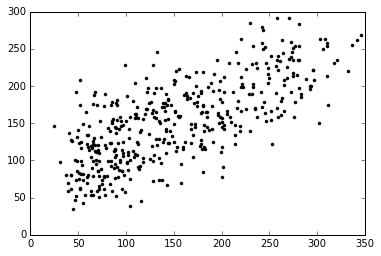

2859.6903987680657

In [16]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

clf = linear_model.LinearRegression()
clf.fit(X, y)

plt.plot(y, clf.predict(X), 'k.')
plt.show()

from sklearn import metrics

metrics.mean_squared_error(y, clf.predict(X))

Although this single number might seem unimpressive, metrics are a key component for model evaluation. As a simple example, we can perform a permutation test to determine whether we might see this performance by chance.

In [35]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

clf = linear_model.LinearRegression()
clf.fit(X, y)

error = metrics.mean_squared_error(y, clf.predict(X))

rounds = 1000
np.random.seed(0)
errors = []

for i in range(rounds):
    y_shuffle = y.copy()
    np.random.shuffle(y_shuffle)
    clf_shuffle = linear_model.LinearRegression()
    clf_shuffle.fit(X, y_shuffle)
    errors.append(metrics.mean_squared_error(y_shuffle, clf_shuffle.predict(X)))

better_models_by_chance = len([i for i in errors if i <= error])

if better_models_by_chance > 0:
    print('Probability of observing a mean_squared_error of {0} by chance is {1}'.format(error, 
                                                                                    better_models_by_chance / rounds))
else:
    print('Probability of observing a mean_squared_error of {0} by chance is <{1}'.format(error, 
                                                                                    1 / rounds))

Probability of observing a mean_squared_error of 2859.6903987680657 by chance is <0.001


### Training, validation, and test datasets

When evaluating different models the approach taken above is not going to work. Particularly for models with high variance, that overfit the training data, we will get very good performance on the training data but perform no better than chance on new data.

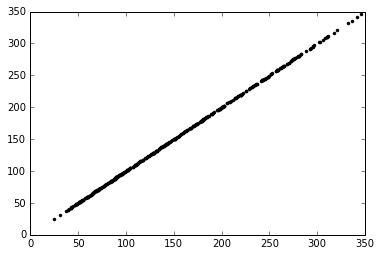

0.0

In [19]:
from sklearn import tree

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

clf = tree.DecisionTreeRegressor()
clf.fit(X, y)

plt.plot(y, clf.predict(X), 'k.')
plt.show()


metrics.mean_squared_error(y, clf.predict(X))

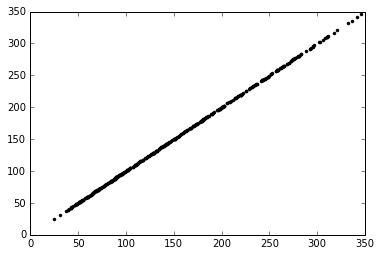

0.0

In [36]:
from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

clf = neighbors.KNeighborsRegressor(n_neighbors=1)
clf.fit(X, y)

plt.plot(y, clf.predict(X), 'k.')
plt.show()


metrics.mean_squared_error(y, clf.predict(X))

Both these models appear to give perfect solutions but all they do is map our test samples back to the training samples and return the associated value.

To understand how our model truly performs we need to evaluate the performance on previously unseen samples. The general approach is to divide a dataset into training, validation and test datasets. Each model is trained on the training dataset. Multiple models can then be compared by evaluating the model against the validation dataset. There is still the potential of choosing a model that performs well on the validation dataset by chance so a final check is made against a test dataset.

This unfortunately means that part of our, often expensively gathered, data can't be used to train our model. Although it is important to leave out a test dataset an alternative approach can be used for the validation dataset. Rather than just building one model we can build multiple models, each time leaving out a different validation dataset. Our validation score is then the average across each of the models. This is known as cross-validation.

Scikit-learn provides classes to support cross-validation but a simple solution can also be implemented directly. Below we will separate out a test dataset to evaluate the nearest neighbor model.

(298, 10) (144, 10)


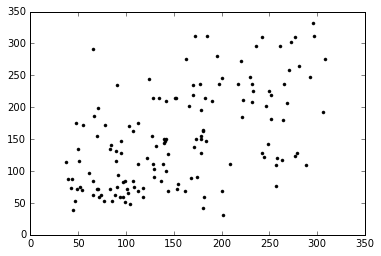

5176.9236111111113

In [29]:
from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

clf = neighbors.KNeighborsRegressor(1)
clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()


metrics.mean_squared_error(y_test, clf.predict(X_test))

(298, 10) (144, 10)


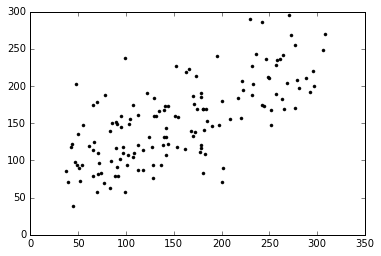

2859.9079113220382

In [30]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

clf = linear_model.LinearRegression()
clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()


metrics.mean_squared_error(y_test, clf.predict(X_test))

## Model types

Scikit-learn includes a variety of [different models](http://scikit-learn.org/stable/supervised_learning.html). The most commonly used algorithms probably include the following:

* Regression
* Support Vector Machines
* Nearest neighbors
* Decision trees
* Ensembles & boosting

### Regression

We have already seen several examples of regression. The basic form is: 

$$f(X) =  \beta_{0}  +  \sum_{j=1}^p X_j\beta_j$$

Each feature is multipled by a coefficient and then the sum returned. This value is then transformed for classification to limit the value to the range 0 to 1.


### Support Vector Machines

Support vector machines attempt to project samples into a higher dimensional space such that they can be divided by a hyperplane. A good explanation can be found in [this article](http://noble.gs.washington.edu/papers/noble_what.html).

### Nearest neighbors

Nearest neighbor methods identify a number of samples from the training set that are close to the new sample and then return the average or most common value depending on the task. 

### Decision trees

Decision trees attempt to predict the value of a new sample by learning simple rules from the training samples.

### Ensembles & boosting

Ensembles are combinations of other models. Combining different models together can improve performance by boosting generalizability. An average or most common value from the models is returned.

Boosting builds one model and then attempts to reduce the errors with the next model. At each stage the bias in the model is reduced. In this way many weak predictors can be combined into one much more powerful predictor.

I often begin with an ensemble or boosting approach as they typically give very good performance without needing to be carefully optimized. Many of the other algorithms are sensitive to their parameters.

## Parameter selection

Many of the models require several different parameters to be specified. Their performance is typically heavily influenced by these parameters and choosing the best values is vital in developing the best model.

Some models have alternative implementations that handle parameter selection in an efficient way.

(442, 10) (442,)
Alpha chosen was  0.0532086795258


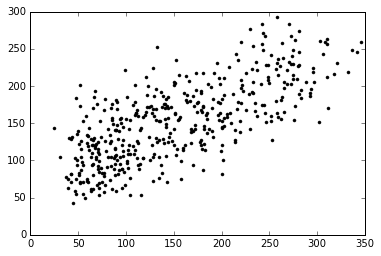

In [31]:
from sklearn import datasets

diabetes = datasets.load_diabetes()

# Description at http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

X = diabetes.data
y = diabetes.target

print(X.shape, y.shape)

from sklearn import linear_model

clf = linear_model.LassoCV(cv=20)
clf.fit(X, y)

print('Alpha chosen was ', clf.alpha_)

plt.plot(y, clf.predict(X), 'k.')

There is an expanded example in [the documentation](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#example-linear-model-plot-lasso-model-selection-py).

There are also general classes to handle parameter selection for situations when dedicated classes are not available. As we will often have parameters in preprocessing steps these general classes will be used much more often.

(298, 10) (144, 10)


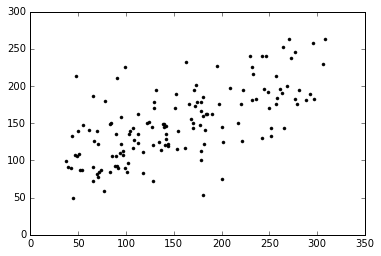

3140.59190538


{'cv': None,
 'error_score': 'raise',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': 1,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': None,
 'verbose': 0}

In [34]:
from sklearn import grid_search

from sklearn import neighbors

diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

np.random.seed(0)

split = np.random.random(y.shape) > 0.3

X_train = X[split]
y_train = y[split]
X_test = X[np.logical_not(split)]
y_test = y[np.logical_not(split)]

print(X_train.shape, X_test.shape)

knn = neighbors.KNeighborsRegressor()

parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
clf = grid_search.GridSearchCV(knn, parameters)

clf.fit(X_train, y_train)

plt.plot(y_test, clf.predict(X_test), 'k.')
plt.show()


print(metrics.mean_squared_error(y_test, clf.predict(X_test)))

clf.get_params()

## Exercises

1. Load the handwritten digits dataset and choose an appropriate metric
2. Divide the data into a training and test dataset
4. Build a RandomForestClassifier on the training dataset, using cross-validation to evaluate performance
5. Choose another classification algorithm and apply it to the digits dataset. 
6. Use grid search to find the optimal parameters for the chosen algorithm.
7. Comparing the true values with the predictions from the best model identify the numbers that are most commonly confused.